## 0.빠른 시작

### 데이터 작업하기

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:01<00:00, 15640333.45it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 310287.75it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5449564.00it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14973839.80it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### 모델 만들기

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# __init__ 함수에서 신경망의 계층(layer)들을 정의
#forward 함수에서 신경망에 데이터를 어떻게 전달할지 지정
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### 모델 매개변수 최적화하기

In [5]:
#모델 학습을 위해선 loss function와 optimizer가 필요함
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        #예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        #예측 오류를 역전파해서 모델의 매개변수 조정
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
#test set으로 데이터셋 성능 확인
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
#학습 단계는 epoch를 거쳐서 수행됨. 각 epoch에서 모델은 더 나은 예측을 위한 매개변수를 학습.
#각 epoch마다 모델의 정확도와 loss를 출력.점차 정확도가 증가, 손실은 감소하는 것을 보게됨
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.309741  [   64/60000]
loss: 2.297788  [ 6464/60000]
loss: 2.283698  [12864/60000]
loss: 2.276109  [19264/60000]
loss: 2.255478  [25664/60000]
loss: 2.234489  [32064/60000]
loss: 2.244915  [38464/60000]
loss: 2.216423  [44864/60000]
loss: 2.204737  [51264/60000]
loss: 2.185675  [57664/60000]
Test Error: 
 Accuracy: 45.3%, Avg loss: 2.172925 

Epoch 2
-------------------------------
loss: 2.183540  [   64/60000]
loss: 2.170296  [ 6464/60000]
loss: 2.121872  [12864/60000]
loss: 2.133867  [19264/60000]
loss: 2.079871  [25664/60000]
loss: 2.030310  [32064/60000]
loss: 2.060416  [38464/60000]
loss: 1.985503  [44864/60000]
loss: 1.985230  [51264/60000]
loss: 1.928761  [57664/60000]
Test Error: 
 Accuracy: 48.4%, Avg loss: 1.915155 

Epoch 3
-------------------------------
loss: 1.947810  [   64/60000]
loss: 1.914158  [ 6464/60000]
loss: 1.807526  [12864/60000]
loss: 1.843659  [19264/60000]
loss: 1.729419  [25664/60000]
loss: 1.684372  [32064/600

### 모델 저장하기

모델은 internal state dictionary를 serialize해 저장함

In [9]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


### 모델 불러오기

In [10]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [11]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


## 1.텐서(TENSOR)

In [12]:
import torch
import numpy as np

### 텐서 초기화

In [16]:
#데이터로부터 직접 생성
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

In [17]:
#NumPy 배열로부터 생성
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

In [18]:
#다른 텐서로부터 생성
x_ones = torch.ones_like(x_data) # x_data의 속성을 유지
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # x_data의 속성을 덮어씀
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.7920, 0.7969],
        [0.9289, 0.8630]]) 



In [19]:
#무작위(random) 또는 상수(constant) 값을 사용
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.0460, 0.8040, 0.4232],
        [0.6636, 0.4662, 0.3102]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


### 텐서의 속성

In [20]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


### 텐선의 연산

In [21]:
if torch.cuda.is_available():
    tensor = tensor.to("cuda")

In [22]:
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:,1] = 0
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


### 텐서 합치기

In [23]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


### 산술 연산

In [24]:
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)

tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])

In [25]:
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

In [26]:
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

12.0 <class 'float'>


In [27]:
print(f"{tensor} \n")
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


### NumPy 변환(Bridge)

### 텐서를 NumPy 배열로 변환

In [28]:
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]


In [29]:
t.add_(1)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


### NumPy 배열을 텐서로 변환

In [31]:
n = np.ones(5)
t = torch.from_numpy(n)

In [32]:
np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
n: [2. 2. 2. 2. 2.]


##2.DATASET과 DATALOADER

### 데이터셋 불러오기

In [33]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [34]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

### 데이터셋을 순회하고 시각화하기

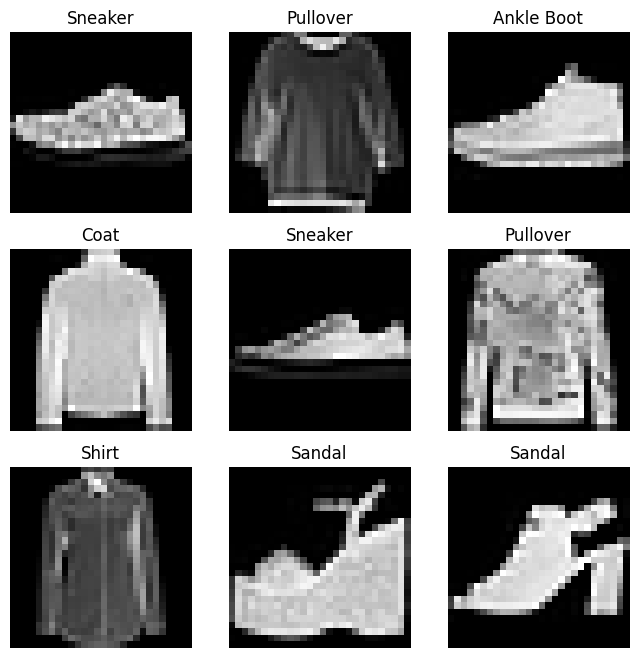

In [35]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### 파일에서 사용자 정의 데이터셋 만들기

사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 합니다: __init__, __len__, and __getitem__.

In [36]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

###__init__

In [38]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

###__len__

In [39]:
def __len__(self):
  return len(self.img_labels)

###__getitem__

In [40]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    sample = {"image": image, "label": label}
    return sample

###DataLoader로 학습용 데이터 준비하기

In [42]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

###DataLoader를 통해 순회하기(iterate)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


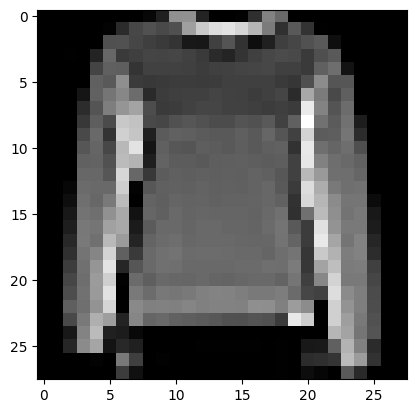

Label: 2


In [43]:
#각 순회(iteration)는 (각각 batch_size=64 의 특징(feature)과 정답(label)을 포함하는) train_features 와 train_labels 의 묶음(batch)을 반환
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

##3.변형(TRANSFORM)

In [44]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

#FashionMNIST 특징(feature)은 PIL Image 형식이며, label은 integer
ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

###Lambda 변형(Transform)

In [45]:
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

##4.신경망 모델 구성하기

In [46]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

###학습을 위한 장치 얻기

In [47]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


###클래스 정의하기

In [48]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [49]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [50]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([5])


###모델 계층(Layer)

In [51]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


####nn.Flatten

In [52]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


####nn.Linear

In [53]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


####nn.ReLU

선형 변환 후에 적용되어 비선형성(nonlinearity) 을 도입하고, 신경망이 다양한 현상을 학습할 수 있도록 함.

In [54]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[-0.0506, -0.1598, -0.2518,  0.2552, -0.2345,  0.2837,  0.2104,  0.0736,
         -0.1403, -0.3161, -0.1677, -0.0393, -0.6583, -0.5327, -0.0788,  0.0182,
         -0.0186,  0.1735,  0.1474, -0.2065],
        [ 0.3387, -0.4381, -0.1811, -0.2517,  0.1593,  0.0644,  0.2391,  0.0250,
         -0.0390,  0.1005, -0.2049,  0.0283, -0.6754, -0.3525, -0.2254,  0.3980,
          0.0950,  0.0956,  0.1598, -0.0568],
        [ 0.5950, -0.2065, -0.2356, -0.3563,  0.0955,  0.1032,  0.4410,  0.1577,
         -0.1791, -0.2899, -0.2016, -0.1280, -0.2322, -0.3682, -0.1818,  0.2310,
         -0.0685,  0.1322,  0.2193, -0.3334]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.0000, 0.0000, 0.2552, 0.0000, 0.2837, 0.2104, 0.0736, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0182, 0.0000, 0.1735,
         0.1474, 0.0000],
        [0.3387, 0.0000, 0.0000, 0.0000, 0.1593, 0.0644, 0.2391, 0.0250, 0.0000,
         0.1005, 0.0000, 0.0283, 0.0000, 0.0000, 0.00

####nn.Sequential

In [55]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

####nn.Softmax

In [56]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

###모델 매개변수

In [57]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0276,  0.0341, -0.0202,  ...,  0.0313, -0.0060,  0.0017],
        [-0.0119,  0.0051,  0.0247,  ..., -0.0297, -0.0143, -0.0062]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0068,  0.0237], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0234, -0.0150, -0.0042,  ..., -0.0305, -0.0296,  0.0358],
        [-0.0117, -0.0240,  0.0167,  ...,  0.0159, -0.0074,  0.0411]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

##5.자동 미분(Automatic Differentiation)

###TORCH.AUTOGRAD를 사용한 자동 미분

In [58]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [59]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7c5d920fb670>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7c5d920fbac0>


###변화도(Gradient) 계산하기

In [60]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2535, 0.3109, 0.1862],
        [0.2535, 0.3109, 0.1862],
        [0.2535, 0.3109, 0.1862],
        [0.2535, 0.3109, 0.1862],
        [0.2535, 0.3109, 0.1862]])
tensor([0.2535, 0.3109, 0.1862])


###변화도 추적 멈추기

In [61]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


In [62]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


###Jacobian Product 계산하기

In [63]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


##6.최적화 단계(Optimization Loop)

###기본(Pre-requisite) 코드

In [65]:
#이전의 코드 불러오기
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

###하이퍼파라미터(Hyperparameter)

In [66]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

###손실함수(loss function)

In [67]:
# 손실 함수 초기화.
loss_fn = nn.CrossEntropyLoss()

###Optimizer

In [68]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

###전체 구현

In [69]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # 예측(prediction)과 손실(loss) 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [70]:
#모델의 성능 향상을 알아보기 위해 자유롭게 에폭(epoch) 수를 증가
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.309138  [   64/60000]
loss: 2.291416  [ 6464/60000]
loss: 2.278186  [12864/60000]
loss: 2.269663  [19264/60000]
loss: 2.244689  [25664/60000]
loss: 2.218614  [32064/60000]
loss: 2.225140  [38464/60000]
loss: 2.194564  [44864/60000]
loss: 2.188267  [51264/60000]
loss: 2.150942  [57664/60000]
Test Error: 
 Accuracy: 50.2%, Avg loss: 2.150322 

Epoch 2
-------------------------------
loss: 2.164406  [   64/60000]
loss: 2.149134  [ 6464/60000]
loss: 2.093787  [12864/60000]
loss: 2.111115  [19264/60000]
loss: 2.053451  [25664/60000]
loss: 1.992399  [32064/60000]
loss: 2.022304  [38464/60000]
loss: 1.945253  [44864/60000]
loss: 1.947253  [51264/60000]
loss: 1.870167  [57664/60000]
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.873729 

Epoch 3
-------------------------------
loss: 1.910227  [   64/60000]
loss: 1.872449  [ 6464/60000]
loss: 1.757505  [12864/60000]
loss: 1.804646  [19264/60000]
loss: 1.686339  [25664/60000]
loss: 1.637630  [32064/600

##7.모델 저장하고 불러오고 사용하기

##모델 가중치 저장하고 불러오기

In [71]:
import torch
import torchvision.models as models

In [72]:
model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model_weights.pth')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 63.9MB/s]


In [73]:
model = models.vgg16()
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

###모델의 형태를 포함하여 저장하고 불러오기

In [74]:
torch.save(model, 'model.pth')

In [75]:
model = torch.load('model.pth')